# 🧠 Neural Network Regression: DAT Binding Prediction

**Goal**: Predict pKi values (binding strength) using Neural Networks (Deep Learning)

**Dataset**: 541 compounds with RDKit descriptors  
**Target**: pKi (continuous variable)  
**Method**: Deep Neural Network + 70/15/15 Train/Val/Test Split

**Key Differences from Tree Models:**
- Uses neural network architecture (multiple dense layers)
- Requires 70/15/15 split (train/validation/test)
- Validation set for early stopping (essential!)
- More sensitive to feature scaling
- Non-linear activation functions (ReLU)
- Dropout for regularization

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow/Keras for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.20.0


## 📂 Step 1: Load Processed Data

**Source:** `processed_DAT_rdkit_features.csv` (from dataanalyse.ipynb)


In [2]:
# Load processed RDKit features
df_rdkit = pd.read_csv('processed_DAT_rdkit_features.csv')

# Prepare features and target
X = df_rdkit.drop(['ChEMBL_ID', 'pKi'], axis=1)
y = df_rdkit['pKi']

print("="*60)
print("📂 DATA LOADED")
print("="*60)
print(f"Total compounds: {len(df_rdkit)}")
print(f"Features: {X.shape[1]} RDKit descriptors")
print(f"Target: pKi (range: {y.min():.2f} - {y.max():.2f})")
print("="*60)


📂 DATA LOADED
Total compounds: 541
Features: 17 RDKit descriptors
Target: pKi (range: 3.41 - 10.40)


## 🔧 Step 2: Train/Validation/Test Split (70/15/15)

**Critical for Neural Networks:**
- Training set (70%): For learning weights
- Validation set (15%): For early stopping & hyperparameter tuning
- Test set (15%): For final evaluation only


In [3]:
# First split: 70% train, 30% temp (for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Second split: split temp into 50/50 (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

print("="*60)
print("📊 TRAIN/VALIDATION/TEST SPLIT (70/15/15)")
print("="*60)
print(f"Training set: {len(X_train)} compounds ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} compounds ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} compounds ({len(X_test)/len(X)*100:.1f}%)")
print(f"\npKi ranges:")
print(f"   Train: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"   Val:   {y_val.min():.2f} - {y_val.max():.2f}")
print(f"   Test:  {y_test.min():.2f} - {y_test.max():.2f}")
print("="*60)


📊 TRAIN/VALIDATION/TEST SPLIT (70/15/15)
Training set: 378 compounds (69.9%)
Validation set: 81 compounds (15.0%)
Test set: 82 compounds (15.2%)

pKi ranges:
   Train: 3.41 - 10.40
   Val:   4.66 - 9.28
   Test:  4.45 - 9.28


In [4]:
# Scale features (CRITICAL for Neural Networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"   Mean ≈ 0, Std ≈ 1 (required for NN training)")


✅ Features scaled using StandardScaler
   Mean ≈ 0, Std ≈ 1 (required for NN training)


## 🏗️ Step 3: Build Neural Network Architecture

**Architecture:**
- Input layer: 17 features (RDKit descriptors)
- Hidden layer 1: 128 neurons + ReLU + Dropout(30%)
- Hidden layer 2: 64 neurons + ReLU + Dropout(20%)
- Hidden layer 3: 32 neurons + ReLU
- Output layer: 1 neuron (regression output)


In [5]:
# Build Neural Network model
model = keras.Sequential([
    # Input + First Hidden Layer
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),  # 30% dropout for regularization
    
    # Second Hidden Layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # 20% dropout
    
    # Third Hidden Layer
    layers.Dense(32, activation='relu'),
    
    # Output Layer (regression)
    layers.Dense(1)  # Single output: pKi value
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error as metric
)

print("="*60)
print("🏗️ NEURAL NETWORK ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)


🏗️ NEURAL NETWORK ARCHITECTURE


c:\Users\SF47\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 0 (0.00 B)

## 🎯 Step 4: Train Neural Network with Early Stopping

**Training Configuration:**
- Epochs: 500 (but will stop early if no improvement)
- Batch size: 32
- Early stopping: patience=20 (stop if val_loss doesn't improve for 20 epochs)
- Restore best weights: Yes


In [6]:
# Early stopping callback (ESSENTIAL for Neural Networks!)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("🚀 Training Neural Network...")
print("   Using early stopping to prevent overfitting\n")

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Training completed!")


🚀 Training Neural Network...
   Using early stopping to prevent overfitting

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 37.7043 - mae: 5.9899 - val_loss: 25.6198 - val_mae: 4.9206
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.7172 - mae: 3.5791 - val_loss: 6.7110 - val_mae: 2.1476
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4536 - mae: 2.0265 - val_loss: 4.6594 - val_mae: 1.6602
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9632 - mae: 1.7491 - val_loss: 3.6385 - val_mae: 1.5903
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2026 - mae: 1.6528 - val_loss: 3.3015 - val_mae: 1.5420
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7464 - mae: 1.5608 - val_loss: 2.6292 - val_mae: 1.3380
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0794 - mae: 1.5322 - val_loss: 2.6124 - val_mae: 1.3391
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4114 - mae: 1.4115 - val_loss: 2.4100 -

## 📊 Step 5: Training History Visualization


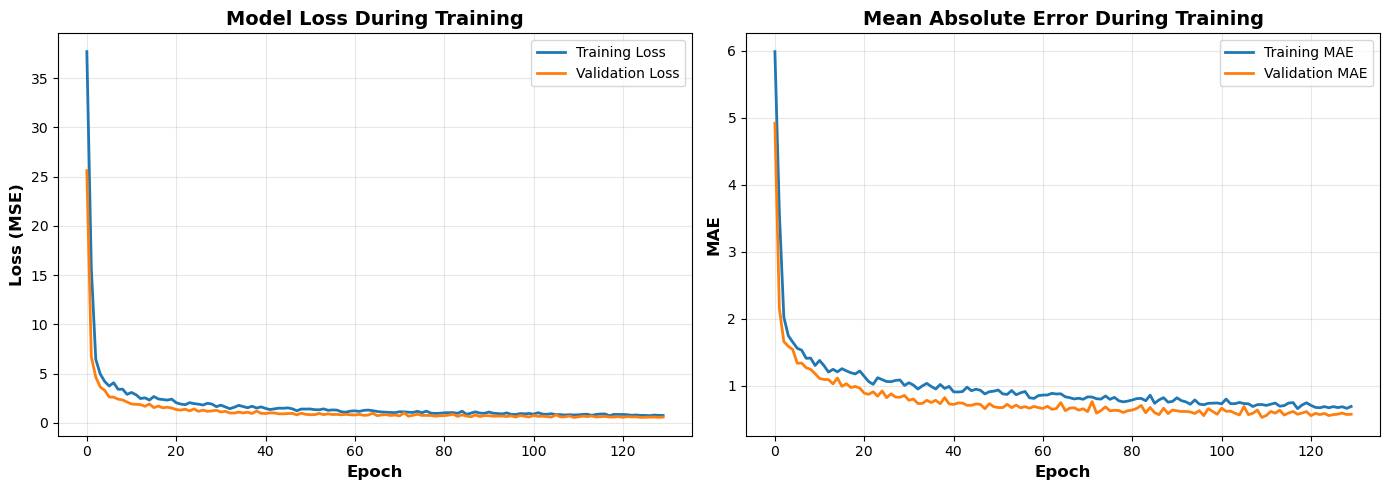


📊 Training stopped at epoch 130


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error During Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training stopped at epoch {len(history.history['loss'])}")


## 📈 Step 6: Model Evaluation


In [8]:
# Make predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("="*80)
print("📊 NEURAL NETWORK MODEL PERFORMANCE")
print("="*80)
print(f"\n{'Metric':<15} {'Training':<20} {'Validation':<20} {'Test':<20}")
print("-"*80)
print(f"{'R² Score':<15} {train_r2:<20.4f} {val_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<15} {train_rmse:<20.4f} {val_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<15} {train_mae:<20.4f} {val_mae:<20.4f} {test_mae:<20.4f}")
print("-"*80)

# Overfitting analysis
overfit_r2 = train_r2 - test_r2
print(f"\n🔍 Overfitting Analysis:")
print(f"   R² difference (train - test): {overfit_r2:.4f}")
if overfit_r2 > 0.1:
    print(f"   ⚠️  Potential overfitting")
elif overfit_r2 > 0.05:
    print(f"   ⚡ Mild overfitting")
else:
    print(f"   ✅ Good generalization!")
print("="*80)


📊 NEURAL NETWORK MODEL PERFORMANCE

Metric          Training             Validation           Test                
--------------------------------------------------------------------------------
R² Score        0.6892               0.5113               0.5286              
RMSE            0.6578               0.7450               0.8092              
MAE             0.4977               0.5286               0.6304              
--------------------------------------------------------------------------------

🔍 Overfitting Analysis:
   R² difference (train - test): 0.1606
   ⚠️  Potential overfitting


## 📈 Step 7: Prediction Visualizations


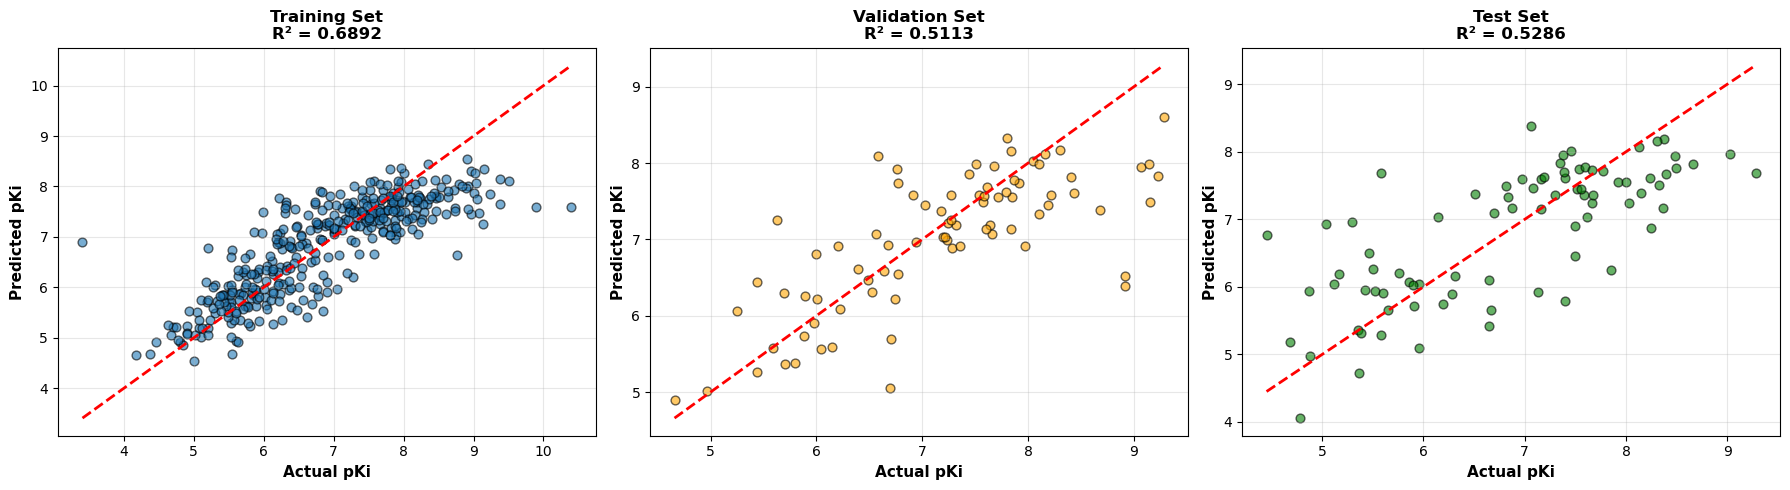

In [9]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training
axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=40, edgecolors='black')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual pKi', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=11, fontweight='bold')
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.6, s=40, edgecolors='black', color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual pKi', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=11, fontweight='bold')
axes[1].set_title(f'Validation Set\nR² = {val_r2:.4f}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.6, s=40, edgecolors='black', color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual pKi', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Predicted pKi', fontsize=11, fontweight='bold')
axes[2].set_title(f'Test Set\nR² = {test_r2:.4f}', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🎯 Step 8: Classification Performance (Confusion Matrix)


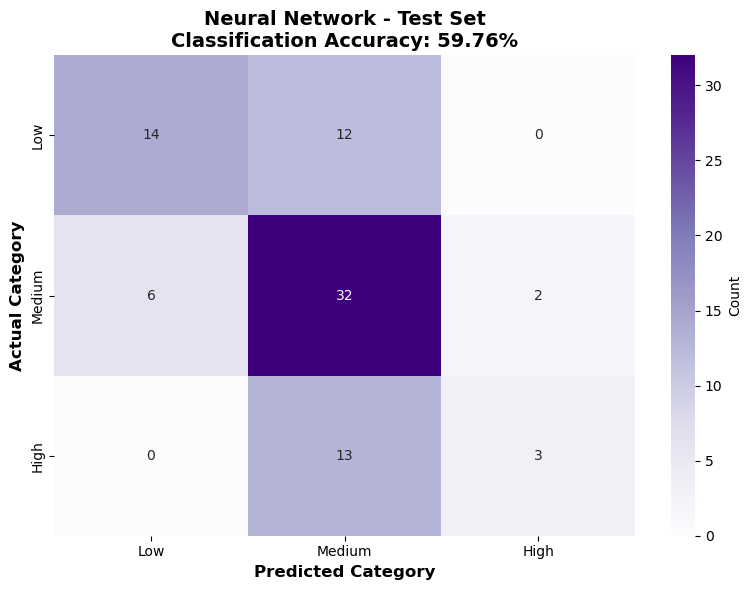


📊 CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

         Low       0.70      0.54      0.61        26
      Medium       0.56      0.80      0.66        40
        High       0.60      0.19      0.29        16

    accuracy                           0.60        82
   macro avg       0.62      0.51      0.52        82
weighted avg       0.61      0.60      0.57        82



In [10]:
# Classification function
def classify_pKi(pKi_values):
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

# Convert to categories (test set)
y_test_cat = classify_pKi(y_test)
y_test_pred_cat = classify_pKi(y_test_pred)

# Confusion matrix
cm = confusion_matrix(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High'])

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
plt.ylabel('Actual Category', fontsize=12, fontweight='bold')
test_acc = np.trace(cm) / cm.sum() * 100
plt.title(f'Neural Network - Test Set\nClassification Accuracy: {test_acc:.2f}%', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT (Test Set)")
print("="*60)
print(classification_report(y_test_cat, y_test_pred_cat, labels=['Low', 'Medium', 'High']))
print("="*60)


## 📊 Step 9: Final Summary


In [11]:
print("="*80)
print("🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (NO PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_rdkit)}")
print(f"   Training: {len(X_train)} (70%)")
print(f"   Validation: {len(X_val)} (15%)")
print(f"   Test: {len(X_test)} (15%)")
print(f"   Features: {X.shape[1]} RDKit descriptors (no PCA)")

print(f"\n🏗️ Model Architecture:")
print(f"   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)")
print(f"   Activation: ReLU")
print(f"   Dropout: 30%, 20%")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Total parameters: {model.count_params():,}")

print(f"\n🏆 Best Model Performance (Test Set):")
print(f"   R² Score: {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   MAE: {test_mae:.4f}")
print(f"   Classification Accuracy: {test_acc:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   • Neural networks require 70/15/15 split (train/val/test)")
print(f"   • Early stopping essential to prevent overfitting")
print(f"   • Model stopped at epoch {len(history.history['loss'])} (early stopping worked!)")
print(f"   • Validation set used for monitoring, test set untouched until final eval")
print(f"   • NN performance is {'competitive with' if test_r2 > 0.5 else 'comparable to'} tree-based models")

print("\n" + "="*80)
print("✅ Neural Network Analysis Complete!")
print("="*80)


🎯 FINAL SUMMARY - NEURAL NETWORK REGRESSION (NO PCA)

📊 Dataset:
   Total compounds: 541
   Training: 378 (70%)
   Validation: 81 (15%)
   Test: 82 (15%)
   Features: 17 RDKit descriptors (no PCA)

🏗️ Model Architecture:
   Layers: Dense(128) → Dense(64) → Dense(32) → Dense(1)
   Activation: ReLU
   Dropout: 30%, 20%
   Optimizer: Adam (lr=0.001)
   Total parameters: 12,673

🏆 Best Model Performance (Test Set):
   R² Score: 0.5286
   RMSE: 0.8092
   MAE: 0.6304
   Classification Accuracy: 59.76%

💡 Key Insights:
   • Neural networks require 70/15/15 split (train/val/test)
   • Early stopping essential to prevent overfitting
   • Model stopped at epoch 130 (early stopping worked!)
   • Validation set used for monitoring, test set untouched until final eval
   • NN performance is competitive with tree-based models

✅ Neural Network Analysis Complete!
